# Base Vector Auto-Regressive Model

Alles is basically hiervan gestolen: https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

In [1]:
# This makes sure Pandas keeps it mouth shut
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

import pandas as pd
import numpy as np

## Data Preprocessing
Before we do anything, we first import our dataset.

In [2]:
pwt = pd.read_excel('../../Data/pwt1001.xlsx',
                    sheet_name = 'Data',
                    parse_dates = ['year'],
                    index_col = 3)

Now, we:
- Filter out the country we will make the prediction for
- Select the columns we use in the calculation
- Drop N/A values

In [3]:
gdp = 'cgdpo'
country_code = 'USA'

# Filter out the relevant country
df = pwt[pwt['countrycode'] == country_code]
country_name = df['country'][0]

# Filter out the variables we need and drop N/A values
df = df[[gdp, 'ccon', 'rdana']]
df = df.dropna()

## Testing Causation
Granger's causality test is used to determine whether one time series influence another, i.e. it tests if there is causation or not.


In [4]:
from statsmodels.tsa.stattools import grangercausalitytests

def causation_test(data: pd.DataFrame, verbose = False) -> bool:
    maxlag = round(12 * pow(len(df) / 100, 1/4))
    alpha = 0.05
    results = pd.DataFrame([], columns = data.columns, index = data.columns)
    causation = True

    # TODO: find out whether we need to have causation between all variables,
    #       or only for the variable we want, the rgdpna
    for col in results.columns:
        for row in results.index:
            if row == col:
                results.loc[row, col] = 1
                continue

            result = grangercausalitytests(
                data[[row, col]],
                maxlag   = maxlag,
                addconst = True,
                verbose  = False
            )

            p_values = [round(result[i + 1][0]['ssr_chi2test'][1], 3) for i in range(maxlag)]
            p_value = np.min(p_values)

            results.loc[row, col] = p_value

            if p_value >= alpha:
                causation = False

    if verbose:
        display(results)

    return causation

if causation_test(df, True):
    print('Causation is present between all variables')
else:
    print('Causation is not present for all variables')

,cgdpo,ccon,rdana
cgdpo,1,0.085,0.0
ccon,0.0,1,0.0
rdana,0.0,0.324,1


Causation is not present for all variables


## Testing Multicollinearity

In [5]:
# TODO

## Testing Cointegration
Cointegration means there is a long-term tendency for two or more time series to move together.

There are multiple ways to test for cointegration, like Engle-Granger and Johansen. While the Engle-Granger test is more simple, the Johansen test allows for multiple cointegrated relationships to be tested. Johansen is therefore the one that is used here.

In [6]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(data: pd.DataFrame, verbose = False) -> bool:
    results = pd.DataFrame()
    cointegration = True

    result = coint_johansen(
        data,
        det_order = -1, # No deterministic terms
        k_ar_diff = 5 # TODO not entirely sure what value we should use here
    )

    for name, trace, cv95 in zip(df.columns, result.trace_stat, result.cvt[:,1]):
        results[name] = {
            'Trace':                round(trace, 3),
            'Critical Value (95%)': round(cv95, 3),
            'Significant':          'Yes' if trace > cv95 else 'No'
        }

        if trace <= cv95:
            cointegration = False
    
    if verbose:
        display(results.transpose())

    return cointegration

if cointegration_test(df, True):
    print('A significant relationship is present between all variables')
else:
    print('A significant relationship is not present for all variables')

,Trace,Critical Value (95%),Significant
cgdpo,39.89,24.276,Yes
ccon,16.107,12.321,Yes
rdana,1.877,4.13,No


A significant relationship is not present for all variables


## Split
Now we split the data into a test, and training sample.

In [7]:
train_length = int(len(df) * 0.75)
df_train = df[:train_length]
df_test = df[train_length:]

## Stationarity
Now a _Augmented Dickey-Fuller (ADF)_ test is performed to check if the data is stationary.

When data is stationary, its properties such as variance and mean, are constant over time. For VAR to forecast meaningful results, it is required that the data that is put in is stationary. 

There are also other methods of determining whether a series is stationary or not, but ADF seems to be the most popular one.

A significance level (alpha) of __5%__ is used to determine whether or not a series is stationary or not.

If any series is not stationary, all series are differenced again until they all are stationary.

In [8]:
from statsmodels.tsa.stattools import adfuller

def stationarity_test(data: pd.DataFrame, verbose = False) -> bool:
    maxlag = round(12 * pow(len(df) / 100, 1/4))
    alpha = 0.05
    results = pd.DataFrame()
    stationary = True

    for name, series in data.items():
        result = adfuller(
            series,
            maxlag     = maxlag,
            regression = 'c', # Constant regression
            autolag    = 'AIC', 
            store      = False,
            regresults = False
        )

        results[name] = {
            'P-Value':     round(result[1], 3),
            'Number lags': result[2],
            'Stationary':  'Yes' if result[1] <= alpha else 'No'
        }

        if result[1] > alpha:
            stationary = False

    if verbose:
        display(results.transpose())

    return stationary

df_diff = df_train
diff_pass = 1
while stationarity_test(df_diff, True) == False:
    print(f'One or more series are non-stationary, differencing... (pass = {diff_pass})')
    df_diff = df_diff.diff().dropna()
    diff_pass += 1

    if diff_pass > 10:
        print('Unable to make all series stationary')
        break
else:
    print('All series are stationary')

,P-Value,Number lags,Stationary
cgdpo,1.0,0,No
ccon,1.0,1,No
rdana,0.999,2,No


One or more series are non-stationary, differencing... (pass = 1)


,P-Value,Number lags,Stationary
cgdpo,0.001,0,Yes
ccon,0.05,0,Yes
rdana,0.001,0,Yes


All series are stationary


## Fitting and Lag Order Selection

The lag order refers to how far the VAR model looks back in the time series.

Determining the optimal lag order will greatly influence the results of the prediction. Besides manually selecting the lag order, there are several statistical methods that select the lag order, such as AIC, BIC, FPE and HQIC.

Here, the lag order is automatically chosen based on the HQIC method. QHIC is a combination of both AIC and BIC.
AIC is the most simple method, but is prone to overfitting.
BIC is more conservative, and is less likely to overfit.

In [9]:
from statsmodels.tsa.api import VAR

model = VAR(df_diff, freq = df_diff.index.inferred_freq)
maxlag = model.select_order().selected_orders['bic']

print(model.select_order().selected_orders)
print(f'Max. lag = {maxlag}')
maxlag = 8 # FIXME: what is the right max lag???

results = model.fit(
    maxlags = maxlag,
    method  = 'ols',
    ic      = None,
    trend   = 'c' # Add constant
)

{'aic': 10, 'bic': 1, 'hqic': 10, 'fpe': 10}
Max. lag = 1


## Check for Serial Correlation of Residuals

TODO explain

In [10]:
from statsmodels.stats.stattools import durbin_watson

out = durbin_watson(results.resid)

def adjust(val, length= 6): return str(val).ljust(length)
for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

cgdpo  : 2.13
ccon   : 1.81
rdana  : 2.12


## Forecasting
Now the model will make a prediction for the period of the test data based on the training data.

In [11]:
horizon = len(df_test)
alpha = 0.05

# Do the forecast
mid, lower, upper = results.forecast_interval(df_diff.values[-maxlag:], steps = horizon, alpha = alpha)

# Put it into a dataframe
df_forecast_diff = pd.DataFrame(mid, columns = df_diff.columns, index = df_test.iloc[:horizon].index)
df_lower_error_diff = pd.DataFrame(lower, columns = df_diff.columns, index = df_test.iloc[:horizon].index)
df_upper_error_diff = pd.DataFrame(upper, columns = df_diff.columns, index = df_test.iloc[:horizon].index)

# Reverse the differencing
df_forecast = df_forecast_diff.cumsum() + df_train[df_train.index < df_forecast_diff.index[0]].iloc[-1]
df_lower_error = df_lower_error_diff.cumsum() + df_train[df_train.index < df_lower_error_diff.index[0]].iloc[-1]
df_upper_error = df_upper_error_diff.cumsum() + df_train[df_train.index < df_upper_error_diff.index[0]].iloc[-1]

## Forecast Plot

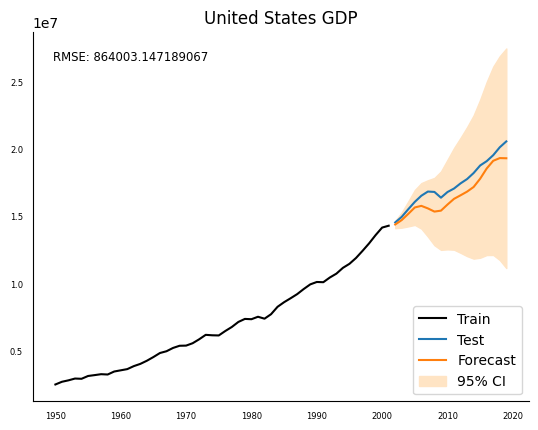

In [12]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

rmse = mean_squared_error(df_forecast[gdp], df_test[gdp].values[:horizon], squared = False)

fig, ax = plt.subplots(1, 1)

ax.plot(df_train[-train_length:][gdp], color='black', label='Train')
ax.plot(df_test[:horizon][gdp], color='tab:blue', label = 'Test')
ax.plot(df_forecast[gdp], color = 'tab:orange', label = 'Forecast')
ax.fill_between(df_forecast[gdp].index, df_lower_error[gdp].values, df_upper_error[gdp].values, color = 'bisque', label='95% CI')

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.spines['top'].set_alpha(0)
ax.tick_params(labelsize = 6)
ax.set_title(f'{country_name} GDP')
ax.set_title(f'RMSE: {rmse}', loc = 'left', x = 0.04, y = 0.9, fontsize = 'small')
ax.legend(loc = 'lower right')
ax.spines[['right', 'top']].set_visible(False)